In [9]:
import yaml
 
try:
    with open("../config.yaml", "r") as file:
        config = yaml.safe_load(file)
except:
    print("Yaml configuration file not found!")

In [10]:
import pandas as pd

df = pd.read_csv(config['input_data']['file'])
df

,wine_type,wine_category,food_item,food_category,cuisine,pairing_quality,quality_label,description
0,Syrah/Shiraz,Red,smoked sausage,Smoky BBQ,Spanish,2,Poor,Heuristic pairing assessment.
1,Grenache,Red,charcuterie board,Salty Snack,French,3,Neutral,Heuristic pairing assessment.
2,Madeira,Fortified,lemon tart,Dessert,French,4,Good,Acidic wine balances acidic food.
3,Cabernet Sauvignon,Red,roast lamb,Red Meat,Mexican,5,Excellent,Tannic red complements red meat fat.
4,Viognier,White,duck à l’orange,Poultry,Vietnamese,2,Poor,Heuristic pairing assessment.
...,...,...,...,...,...,...,...,...
34928,Merlot,Red,mac and cheese,Cheese,Greek,5,Excellent,Idealized perfect pairing example for contrast.
34929,Sauternes,Dessert,grilled ribeye,Red Meat,Spanish,5,Excellent,Idealized perfect pairing example for contrast.
34930,Sauternes,Dessert,fondue,Cheese,Mexican,1,Terrible,Deliberately bad pairing example for contrast.
34931,Zinfandel,Red,beef stew,Red Meat,Mexican,5,Excellent,Idealized perfect pairing example for contrast.


In [11]:
# Count rows per combination - wine
result_wine = (
    df.groupby(['wine_type', 'wine_category', 'pairing_quality'])
      .size()
      .reset_index(name='count')
      .sort_values(['wine_type', 'wine_category', 'pairing_quality'])
)

print(result_wine)

     wine_type wine_category  pairing_quality  count
0     Albariño         White                1    366
1     Albariño         White                2    305
2     Albariño         White                3    407
3     Albariño         White                4    272
4     Albariño         White                5    375
..         ...           ...              ...    ...
140  Zinfandel           Red                1    180
141  Zinfandel           Red                2    152
142  Zinfandel           Red                3    220
143  Zinfandel           Red                4    220
144  Zinfandel           Red                5    190

[145 rows x 4 columns]


In [12]:
# Combine wine_type + wine_category into one label
result_wine['wine_label'] = result_wine['wine_type'] + ' (' + result_wine['wine_category'] + ')'

# Pivot for plotting
pivot = result_wine.pivot_table(
    index='wine_label',
    columns='pairing_quality',
    values='count',
    fill_value=0
).sort_index()

pivot = pivot.astype(int)

print(pivot)

pairing_quality             1    2    3    4    5
wine_label                                       
Albariño (White)          366  305  407  272  375
Barbera (Red)             122  135  170  136  138
Cabernet Sauvignon (Red)  188  153  221  221  200
Cava (Sparkling)          255  186  289  255  246
Champagne (Sparkling)     253  187  286  254  257
Chardonnay (White)        260  183  302  268  271
Chenin Blanc (White)      119  131  165  134  117
Gamay (Beaujolais) (Red)  193  187  238  153  202
Gewürztraminer (White)    197  221  220  153  157
Grenache (Red)            264  255  305  220  271
Grüner Veltliner (White)  367  306  406  271  374
Ice Wine (Dessert)        515  441  543  424  528
Madeira (Fortified)       202  187  237  204  214
Malbec (Red)              187  153  221  221  196
Merlot (Red)              250  221  305  254  279
Nebbiolo (Red)            339  289  374  238  352
Pinot Noir (Red)          257  187  272  238  252
Port (Fortified)          224  238  238  153  207


In [14]:
# Calculate weighted average rating per wine_label
pivot['avg_rating'] = (
    (pivot[1]*1 + pivot[2]*2 + pivot[3]*3 + pivot[4]*4 + pivot[5]*5)
    / pivot[[1, 2, 3, 4, 5]].sum(axis=1)
)

# Round average rating to 2 decimals for readability
pivot['avg_rating'] = pivot['avg_rating'].round(3)

# Sort wines by highest average rating
pivot_sorted = pivot.sort_values(by='avg_rating', ascending=False)

# Display the top 10 wines with the highest average rating
print(pivot_sorted[['avg_rating']].head(29))

pairing_quality           avg_rating
wine_label                          
Tempranillo (Red)              3.139
Cabernet Sauvignon (Red)       3.094
Syrah/Shiraz (Red)             3.092
Zinfandel (Red)                3.091
Malbec (Red)                   3.088
Chardonnay (White)             3.083
Merlot (Red)                   3.070
Champagne (Sparkling)          3.061
Sangiovese (Red)               3.048
Barbera (Red)                  3.047
Riesling (dry) (White)         3.041
Cava (Sparkling)               3.041
Madeira (Fortified)            3.039
Pinot Noir (Red)               3.034
Provence Rosé (Rosé)           3.032
Ice Wine (Dessert)             3.004
Sauternes (Dessert)            3.002
Torrontés (White)              3.002
Chenin Blanc (White)           2.998
Viognier (White)               2.993
Albariño (White)               2.991
Sauvignon Blanc (White)        2.989
Grüner Veltliner (White)       2.988
Gamay (Beaujolais) (Red)       2.984
Grenache (Red)                 2.984
N

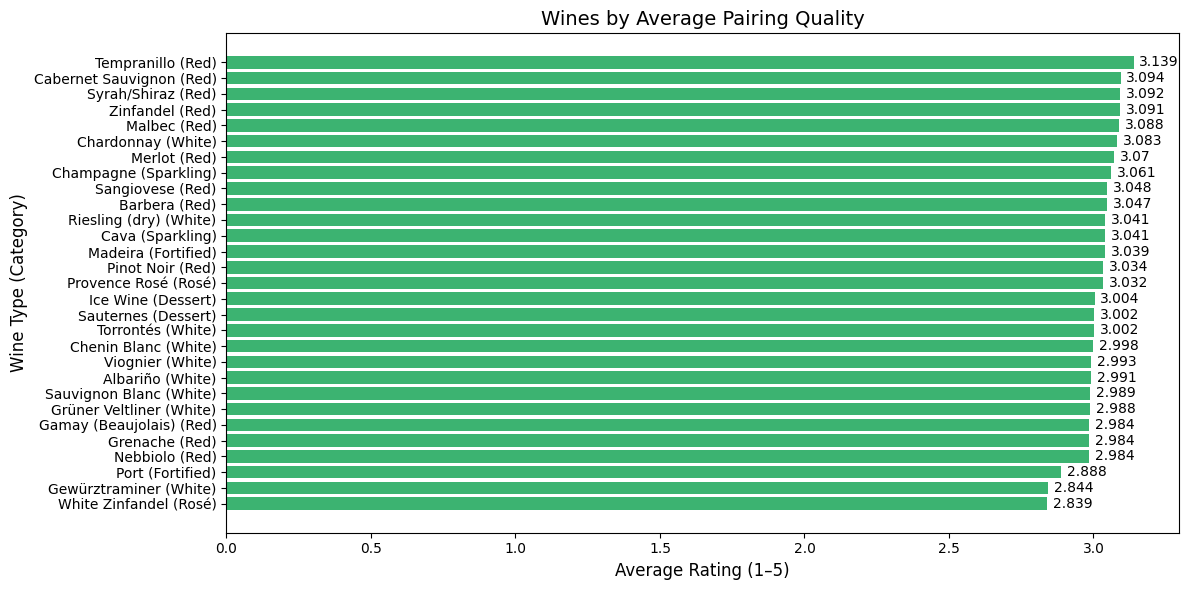

In [15]:
import matplotlib.pyplot as plt

# --- Visualization ---
plt.figure(figsize=(12, 6))
plt.barh(pivot_sorted.index, pivot_sorted['avg_rating'], color='mediumseagreen')
plt.gca().invert_yaxis()  # So the highest-rated wine appears at the top
plt.title('Wines by Average Pairing Quality', fontsize=14)
plt.xlabel('Average Rating (1–5)', fontsize=12)
plt.ylabel('Wine Type (Category)', fontsize=12)

# Add rating labels to the bars
for i, v in enumerate(pivot_sorted['avg_rating']):
    plt.text(v + 0.02, i, str(v), va='center', fontsize=10)

plt.tight_layout()
plt.show()

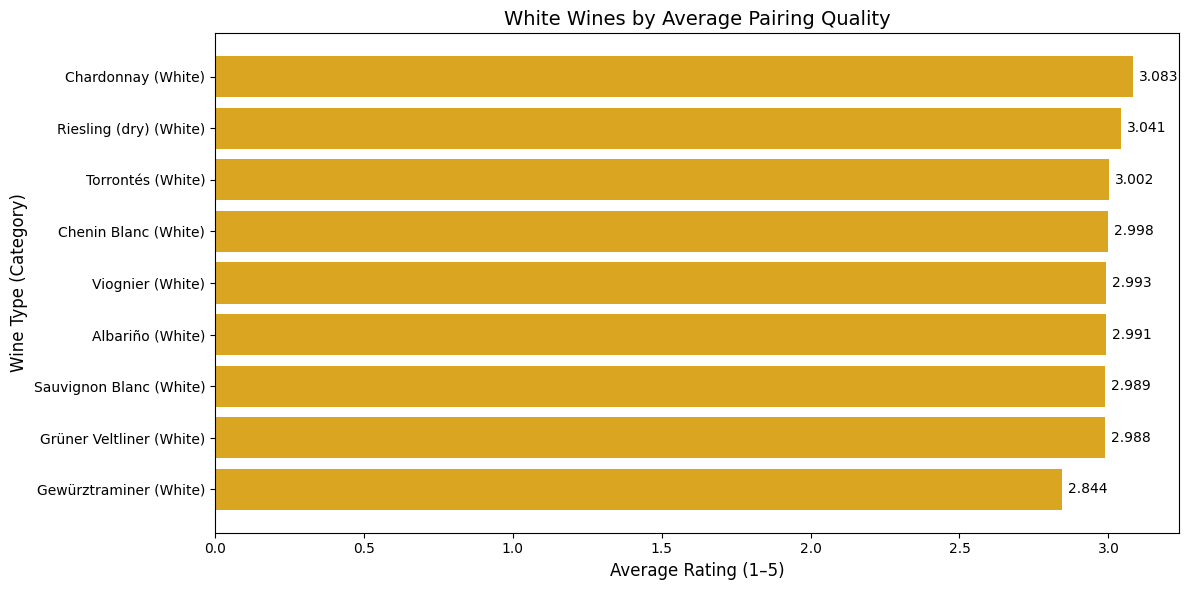

In [18]:
# --- Filter only white wines ---
pivot_white = pivot_sorted[pivot_sorted.index.str.contains(r'\(White\)', case=False, regex=True)]

# --- Visualization ---
plt.figure(figsize=(12, 6))
plt.barh(pivot_white.index, pivot_white['avg_rating'], color='goldenrod')
plt.gca().invert_yaxis()  # Highest-rated wines appear at the top
plt.title('White Wines by Average Pairing Quality', fontsize=14)
plt.xlabel('Average Rating (1–5)', fontsize=12)
plt.ylabel('Wine Type (Category)', fontsize=12)

# Add rating labels to each bar
for i, v in enumerate(pivot_white['avg_rating']):
    plt.text(v + 0.02, i, str(v), va='center', fontsize=10)

plt.tight_layout()
plt.show()

In [19]:
# Total of all average ratings across white wines
total_avg_white = pivot_white['avg_rating'].sum()

# Calculate percentage of total average rating for each white wine
pivot_white['pct_of_total_avg'] = (pivot_white['avg_rating'] / total_avg_white) * 100

# Round for readability
pivot_white['pct_of_total_avg'] = pivot_white['pct_of_total_avg'].round(3)

# Sort by percentage (highest to lowest)
pivot_white_sorted = pivot_white.sort_values(by='pct_of_total_avg', ascending=False)

# Display the top 10 white wines
print(pivot_white_sorted[['avg_rating', 'pct_of_total_avg']])

pairing_quality           avg_rating  pct_of_total_avg
wine_label                                            
Chardonnay (White)             3.083            11.449
Riesling (dry) (White)         3.041            11.293
Torrontés (White)              3.002            11.148
Chenin Blanc (White)           2.998            11.133
Viognier (White)               2.993            11.114
Albariño (White)               2.991            11.107
Sauvignon Blanc (White)        2.989            11.100
Grüner Veltliner (White)       2.988            11.096
Gewürztraminer (White)         2.844            10.561


C:\Users\julia\AppData\Local\Temp\ipykernel_25232\767923336.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pivot_white['pct_of_total_avg'] = (pivot_white['avg_rating'] / total_avg_white) * 100
C:\Users\julia\AppData\Local\Temp\ipykernel_25232\767923336.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pivot_white['pct_of_total_avg'] = pivot_white['pct_of_total_avg'].round(3)


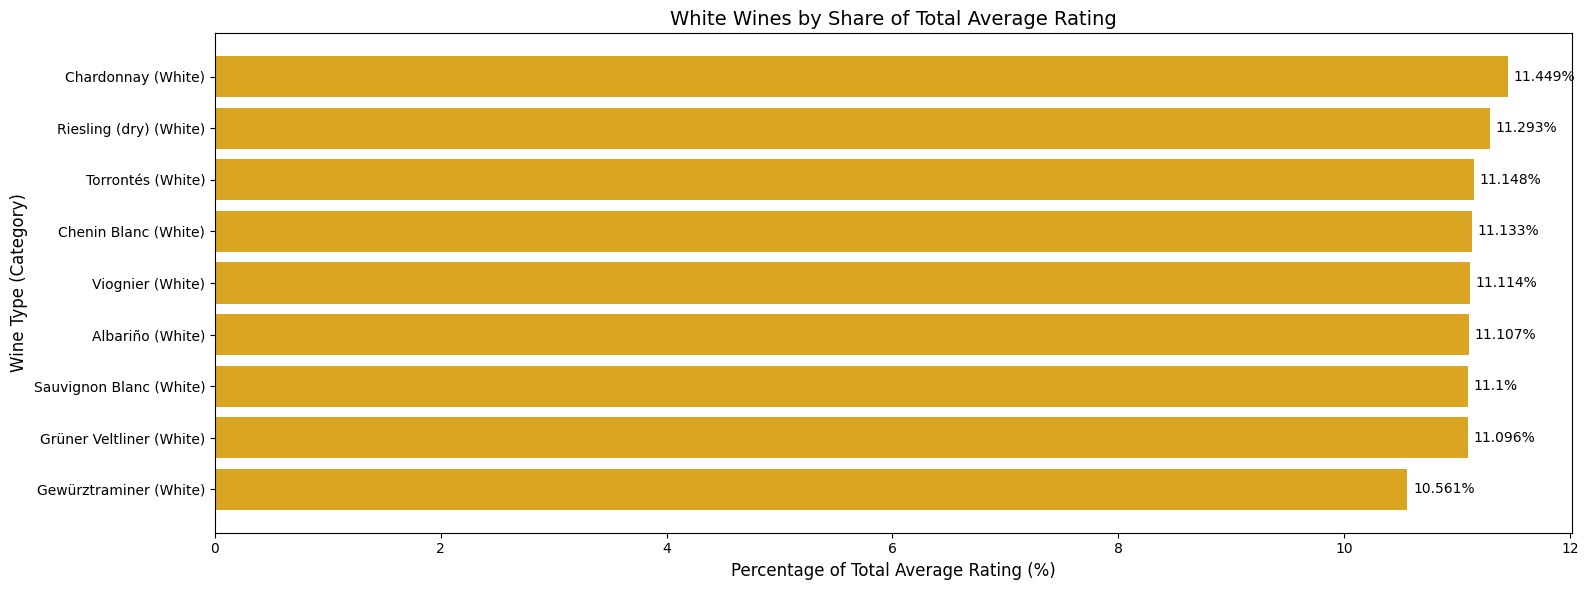

In [21]:
# --- Sort by percentage of total average rating (descending) ---
pivot_white_sorted = pivot_white.sort_values(by='pct_of_total_avg', ascending=False)

# --- Visualization ---
plt.figure(figsize=(16, 6))
plt.barh(pivot_white_sorted.index, pivot_white_sorted['pct_of_total_avg'], color='goldenrod')
plt.gca().invert_yaxis()  # Highest percentage at the top
plt.title('White Wines by Share of Total Average Rating', fontsize=14)
plt.xlabel('Percentage of Total Average Rating (%)', fontsize=12)
plt.ylabel('Wine Type (Category)', fontsize=12)

# Add percentage labels on bars
for i, v in enumerate(pivot_white_sorted['pct_of_total_avg']):
    plt.text(v + 0.05, i, f"{v}%", va='center', fontsize=10)

plt.tight_layout()
plt.show()

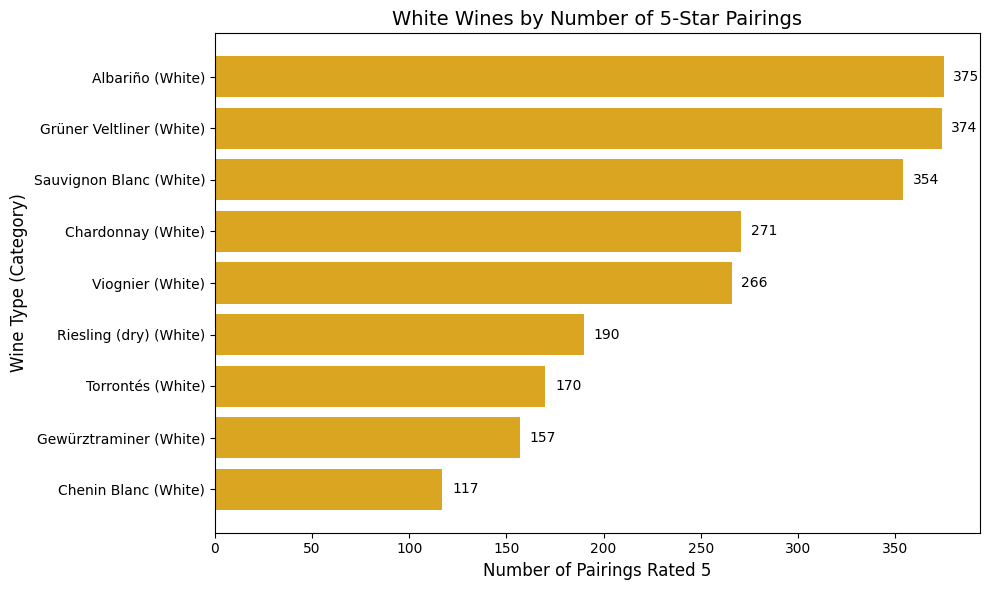

In [23]:
# --- Sort by count of pairing_quality = 5 ---
white_5stars = pivot_white.sort_values(by=5, ascending=False)

# --- Visualization ---
plt.figure(figsize=(10, 6))
plt.barh(white_5stars.index, white_5stars[5], color='goldenrod')
plt.gca().invert_yaxis()  # Highest at top
plt.title('White Wines by Number of 5-Star Pairings', fontsize=14)
plt.xlabel('Number of Pairings Rated 5', fontsize=12)
plt.ylabel('Wine Type (Category)', fontsize=12)

# Add labels to bars
for i, v in enumerate(white_5stars[5]):
    plt.text(v + 5, i, str(v), va='center', fontsize=10)

plt.tight_layout()
plt.show()

In [24]:
# Sum all counts where pairing_quality = 5
total_white_5 = pivot_white[5].sum()

# Calculate each wine’s percentage of total 5-star pairings
pivot_white['pct_of_total_5'] = (pivot_white[5] / total_white_5) * 100

# Round for readability
pivot_white['pct_of_total_5'] = pivot_white['pct_of_total_5'].round(3)

# Sort from highest to lowest percentage
pivot_white_sorted = pivot_white.sort_values(by='pct_of_total_5', ascending=False)

pivot_white_sorted

C:\Users\julia\AppData\Local\Temp\ipykernel_25232\2043927699.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pivot_white['pct_of_total_5'] = (pivot_white[5] / total_white_5) * 100
C:\Users\julia\AppData\Local\Temp\ipykernel_25232\2043927699.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pivot_white['pct_of_total_5'] = pivot_white['pct_of_total_5'].round(3)


pairing_quality,1,2,3,4,5,avg_rating,pct_of_total_avg,pct_of_total_5
wine_label,,,,,,,,
Albariño (White),366,305,407,272,375,2.991,11.107,16.491
Grüner Veltliner (White),367,306,406,271,374,2.988,11.096,16.447
Sauvignon Blanc (White),347,301,405,268,354,2.989,11.100,15.567
Chardonnay (White),260,183,302,268,271,3.083,11.449,11.917
Viognier (White),280,217,299,236,266,2.993,11.114,11.697
Riesling (dry) (White),179,170,220,187,190,3.041,11.293,8.355
Torrontés (White),168,186,219,184,170,3.002,11.148,7.476
Gewürztraminer (White),197,221,220,153,157,2.844,10.561,6.904
Chenin Blanc (White),119,131,165,134,117,2.998,11.133,5.145


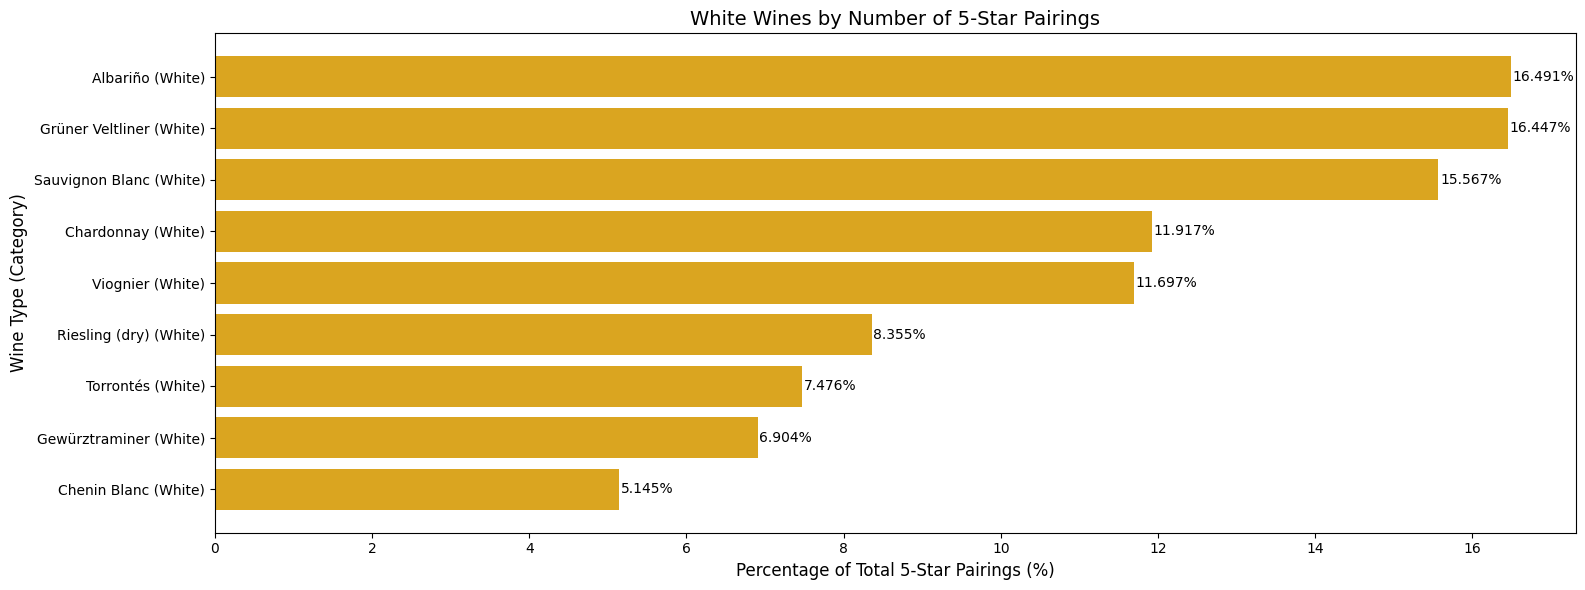

In [25]:
# --- Sort the dataframe ---
pivot_white_sorted = pivot_white.sort_values(by='pct_of_total_5', ascending=False)

# --- Visualization ---
plt.figure(figsize=(16, 6))
plt.barh(pivot_white_sorted.index, pivot_white_sorted['pct_of_total_5'], color='goldenrod')
plt.gca().invert_yaxis()  # Highest at top
plt.title('White Wines by Number of 5-Star Pairings', fontsize=14)
plt.xlabel('Percentage of Total 5-Star Pairings (%)', fontsize=12)
plt.ylabel('Wine Type (Category)', fontsize=12)

# Add labels to bars
for i, v in enumerate(pivot_white_sorted['pct_of_total_5']):
    plt.text(v + 0.02, i, f"{v}%", va='center', fontsize=10)

plt.tight_layout()
plt.show()

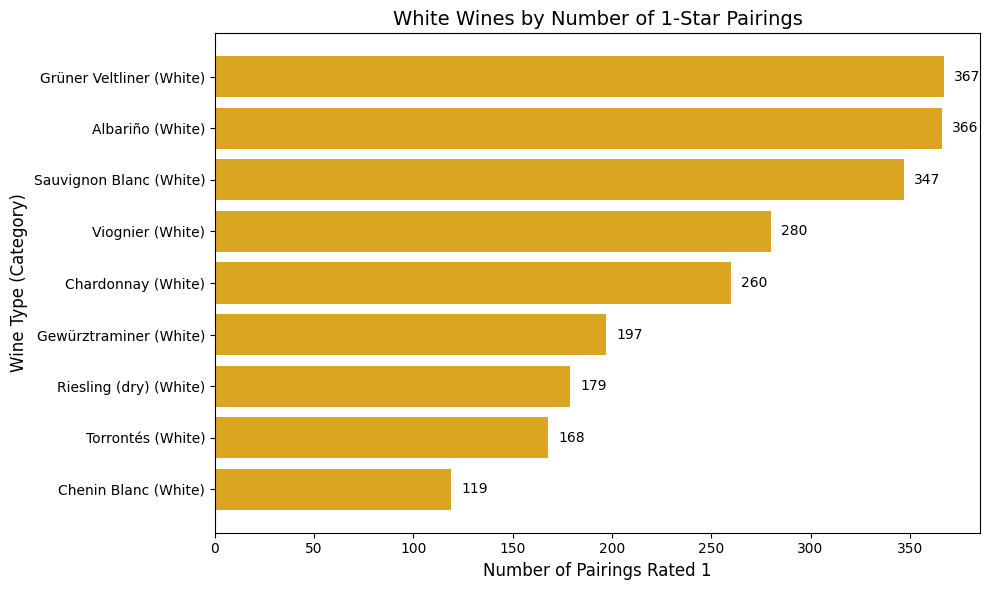

In [27]:
# --- Sort by count of pairing_quality = 1 ---
white_1stars = pivot_white.sort_values(by=1, ascending=False)

# --- Visualization ---
plt.figure(figsize=(10, 6))
plt.barh(white_1stars.index, white_1stars[1], color='goldenrod')
plt.gca().invert_yaxis()  # Highest at top
plt.title('White Wines by Number of 1-Star Pairings', fontsize=14)
plt.xlabel('Number of Pairings Rated 1', fontsize=12)
plt.ylabel('Wine Type (Category)', fontsize=12)

# Add labels to bars
for i, v in enumerate(white_1stars[1]):
    plt.text(v + 5, i, str(v), va='center', fontsize=10)

plt.tight_layout()
plt.show()

In [29]:
# Sum all counts where pairing_quality = 1
total_white_1 = pivot_white[1].sum()

# Calculate each wine’s percentage of total 1-star pairings
pivot_white['pct_of_total_1'] = (pivot_white[1] / total_white_1) * 100

# Round for readability
pivot_white['pct_of_total_1'] = pivot_white['pct_of_total_1'].round(3)

# Sort from highest to lowest percentage
pivot_white_sorted = pivot_white.sort_values(by='pct_of_total_1', ascending=False)

pivot_white_sorted

C:\Users\julia\AppData\Local\Temp\ipykernel_25232\1531887637.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pivot_white['pct_of_total_1'] = (pivot_white[1] / total_white_1) * 100
C:\Users\julia\AppData\Local\Temp\ipykernel_25232\1531887637.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pivot_white['pct_of_total_1'] = pivot_white['pct_of_total_1'].round(3)


pairing_quality,1,2,3,4,5,avg_rating,pct_of_total_avg,pct_of_total_5,pct_of_total_1
wine_label,,,,,,,,,
Grüner Veltliner (White),367,306,406,271,374,2.988,11.096,16.447,16.075
Albariño (White),366,305,407,272,375,2.991,11.107,16.491,16.032
Sauvignon Blanc (White),347,301,405,268,354,2.989,11.100,15.567,15.199
Viognier (White),280,217,299,236,266,2.993,11.114,11.697,12.265
Chardonnay (White),260,183,302,268,271,3.083,11.449,11.917,11.389
Gewürztraminer (White),197,221,220,153,157,2.844,10.561,6.904,8.629
Riesling (dry) (White),179,170,220,187,190,3.041,11.293,8.355,7.841
Torrontés (White),168,186,219,184,170,3.002,11.148,7.476,7.359
Chenin Blanc (White),119,131,165,134,117,2.998,11.133,5.145,5.212


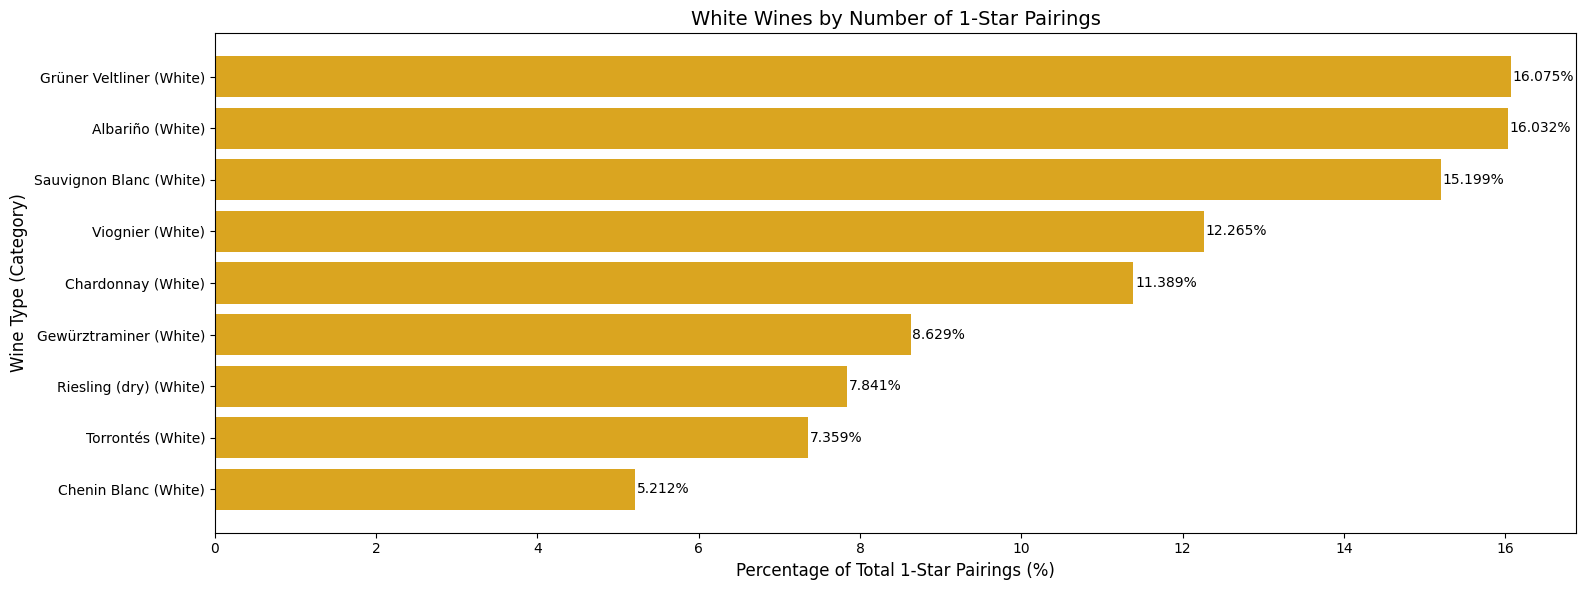

In [30]:
# --- Sort the dataframe ---
pivot_white_sorted = pivot_white.sort_values(by='pct_of_total_1', ascending=False)

# --- Visualization ---
plt.figure(figsize=(16, 6))
plt.barh(pivot_white_sorted.index, pivot_white_sorted['pct_of_total_1'], color='goldenrod')
plt.gca().invert_yaxis()  # Highest at top
plt.title('White Wines by Number of 1-Star Pairings', fontsize=14)
plt.xlabel('Percentage of Total 1-Star Pairings (%)', fontsize=12)
plt.ylabel('Wine Type (Category)', fontsize=12)

# Add labels to bars
for i, v in enumerate(pivot_white_sorted['pct_of_total_1']):
    plt.text(v + 0.02, i, f"{v}%", va='center', fontsize=10)

plt.tight_layout()
plt.show()

C:\Users\julia\AppData\Local\Temp\ipykernel_25232\2999685945.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pivot_white['combined_score'] = pivot_white['pct_of_total_avg'] + pivot_white['pct_of_total_5'] - pivot_white['pct_of_total_1']


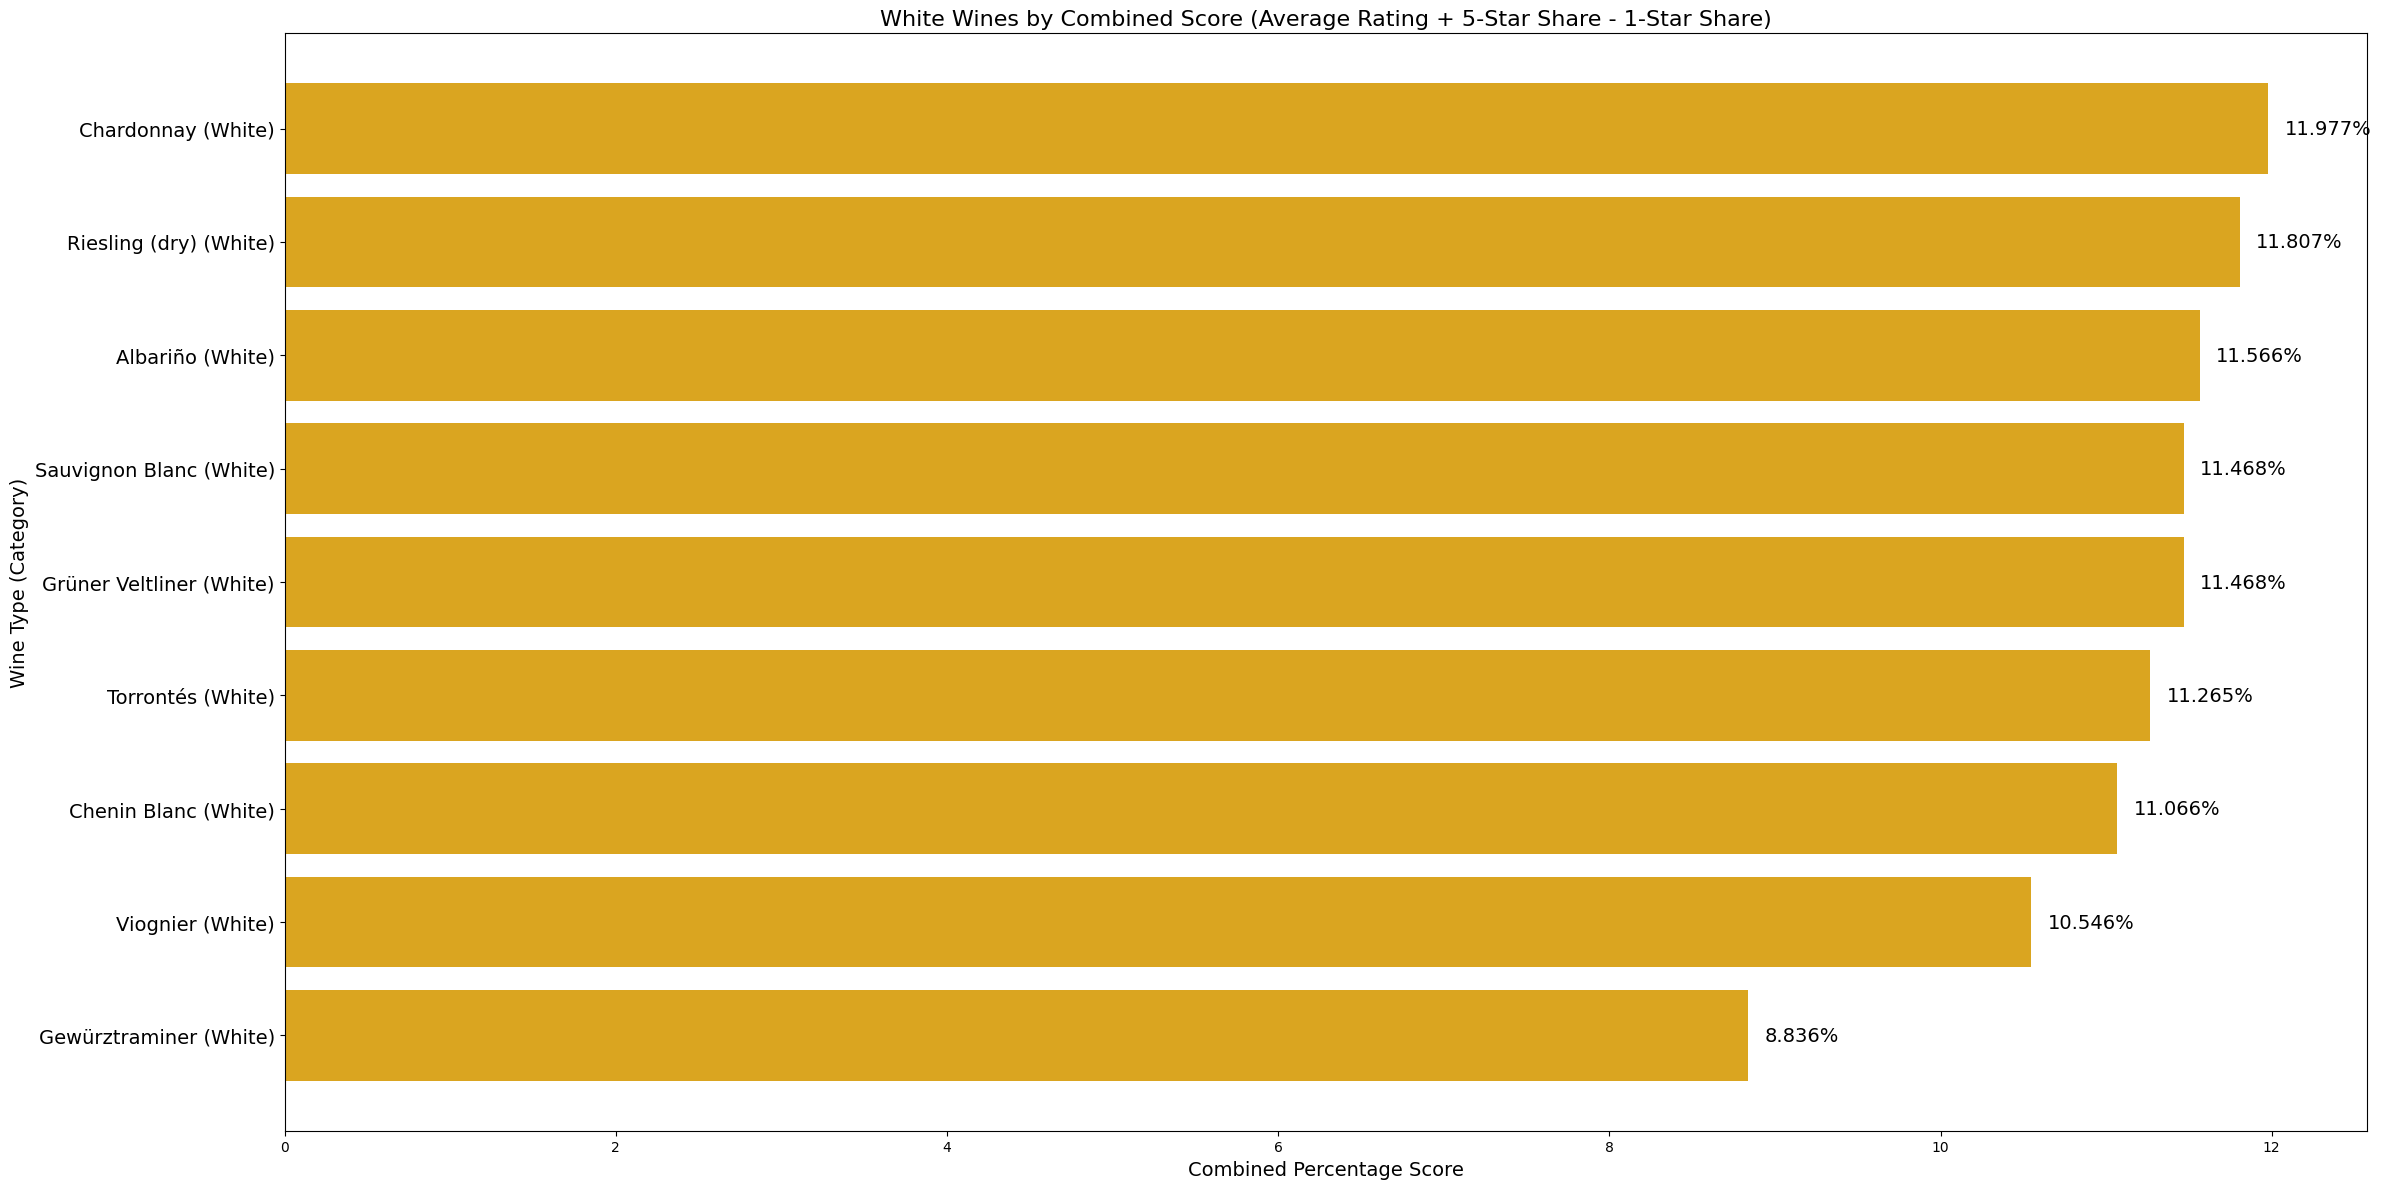

In [42]:
# Ensure both percentage columns exist in the same DataFrame

pivot_white['combined_score'] = pivot_white['pct_of_total_avg'] + pivot_white['pct_of_total_5'] - pivot_white['pct_of_total_1']

# Sort by combined score (descending)
pivot_white_sorted = pivot_white.sort_values(by='combined_score', ascending=False)

# Visualization
plt.figure(figsize=(24, 12))
plt.barh(pivot_white_sorted.index, pivot_white_sorted['combined_score'], color='goldenrod')
plt.gca().invert_yaxis()  # Highest score on top

plt.title('White Wines by Combined Score (Average Rating + 5-Star Share - 1-Star Share)', fontsize=16)
plt.xlabel('Combined Percentage Score', fontsize=14)
plt.ylabel('Wine Type (Category)', fontsize=14)

# Make wine names (y-axis labels) bigger
plt.yticks(fontsize=14)

# Add labels to bars
for i, v in enumerate(pivot_white_sorted['combined_score']):
    plt.text(v + 0.1, i, f"{v:.3f}%", va='center', fontsize=14)

plt.tight_layout()
plt.show()